In [1]:
%matplotlib widget
import os
os.getcwd()
from algorithms import plot

In [2]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("andonians/random-linear-regression")

# get the names of files
files = os.listdir(path)
print(files)

['test.csv', 'train.csv']


In [3]:


# Load into a DataFrame
train_data = '/' + files[1]
testing_data = '/' + files[0]
df = pd.read_csv(path + train_data)

# setting the training data
x_train = np.array(df[['x']])
y_train = np.array(df['y'])

# Find indices of nan values in y_train
nan_indices = np.where(np.isnan(y_train))[0]

# Remove those samples from both x_train and y_train
x_train = np.delete(x_train, nan_indices, axis=0)
y_train = np.delete(y_train, nan_indices, axis=0)


# setting the testing data
df = pd.read_csv(path + testing_data)
x_test = np.array(df[['x']])
y_test = np.array(df['y'])


Let's see our data:

In [4]:
print(f'x_train: \n{x_train[:10]}')
print(f'x_train.shape: \n{x_train.shape} ')

print(f'y_train: \n{y_train[:10]}')
print(f'y_train.shape: \n{y_train.shape} ')

x_train: 
[[24.]
 [50.]
 [15.]
 [38.]
 [87.]
 [36.]
 [12.]
 [81.]
 [25.]
 [ 5.]]
x_train.shape: 
(699, 1) 
y_train: 
[21.54945196 47.46446305 17.21865634 36.58639803 87.28898389 32.46387493
 10.78089683 80.7633986  24.61215147  6.96331907]
y_train.shape: 
(699,) 


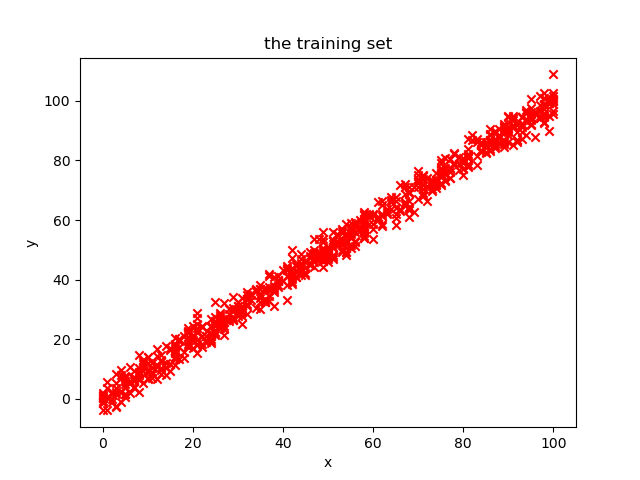

In [5]:
fig, ax = plt.subplots()
ax.set_title("the training set")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(x_train, y_train, color="r", marker='x')

**Now let's try to implement our linear regression model**
which is denoted by: 
first we're going to choose some arbitrary parametrs of f, let's start with

`w` = -1 and `b` = 50

In [6]:
w = np.array([-1.1])
print(w)
b = 50
m, n = x_train.shape
for i in range(10):
    f_wb = np.dot(w, x_train[i]) + b
    print(f_wb)

[-1.1]
23.599999999999998
-5.000000000000007
33.5
8.199999999999996
-45.7
10.399999999999999
36.8
-39.10000000000001
22.499999999999996
44.5


let's try to **visualize that**:

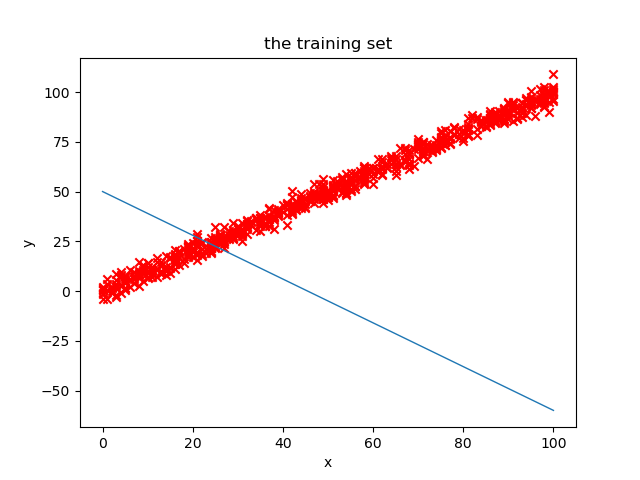

In [7]:
fig, ax = plt.subplots()
ax.set_title("the training set")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(x_train, y_train, color="r", marker='x')
ax.plot(range(101), np.array(range(101)) * w + 50 , lw=1)

Well, as you can see, our model is definitaly not good for making predictions for this set of data.

while it might appear clearly from the figure shown above, sometimes we can't just decide using our eyes.

One way of measuring the quality of our predictions is to use what's a **cost function**, which is denoted by

$$j(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m - 1} (f_{w,b}(x^{(i)}) - y^{(i)})^2$$




In [8]:
def cost_func(x, y, w, b):
    
    f_wb = x @ w + b
    error = f_wb - y
    squared_error = np.square(error)
    # the cost
    j_wb = np.mean(squared_error) / 2 

    return j_wb

In [9]:
print(cost_func(x_train, y_train, w, b))

3361.1009474653065


## ploting the cost function

In [10]:
w_range = np.arange(-2, 4, 0.1)  # try from -1 to 2
b_range = np.arange(-20, 40, 1)

# Create a meshgrid
W, B = np.meshgrid(w_range, b_range)

# Initialize Z with the same shape
Z = np.zeros_like(W)

# Calculate cost for each (w, b) pair
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = cost_func(x_train, y_train, np.array([W[i, j]]), B[i, j])
        

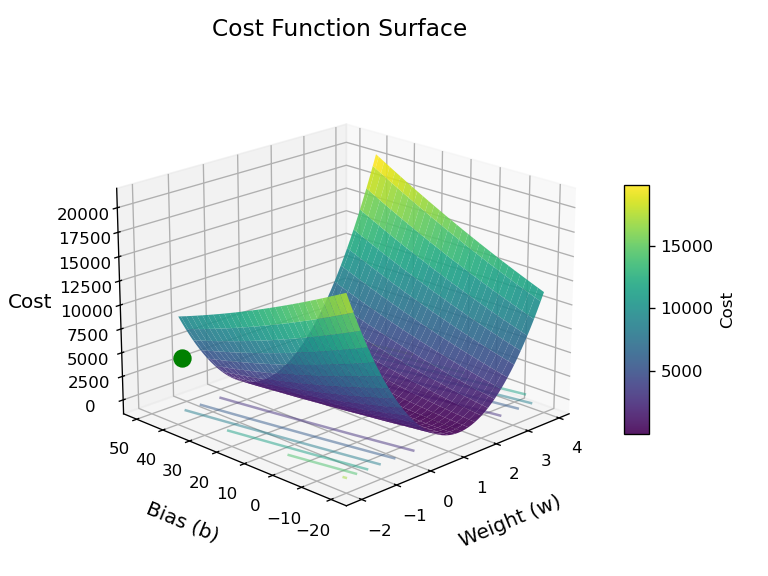

In [11]:
# 5. Create figure with high resolution
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection='3d')

# 6. Plot surface with smooth shading
surf = ax.plot_surface(W, B, Z, cmap='viridis', edgecolor='none', alpha=0.9)

ax.scatter(w, b, cost_func(x_train, y_train ,w, b), color='g', s=100, alpha=1)

# 7. Add contour lines for clarity
ax.contour(W, B, Z, zdir='z', offset=np.min(Z), cmap='viridis', alpha=0.5)

# 8. Labels and title
ax.set_xlabel('Weight (w)', labelpad=10, fontsize=12)
ax.set_ylabel('Bias (b)', labelpad=10, fontsize=12)
ax.set_zlabel('Cost', labelpad=10, fontsize=12)
ax.set_title('Cost Function Surface', fontsize=14, pad=15)

# 9. Color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label='Cost')

# 10. Angle for better 3D viewing
ax.view_init(elev=20, azim=-135 )

plt.tight_layout()
plt.show()

**Now that we've implemented the cost function let's try it on our current model and see how costy it is**

In [12]:
print(cost_func(x_train, y_train, w, b))

3361.1009474653065


now that is a very high cost, let's try to minimize it by using gradient descent


$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align}
$$
Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

In [13]:
def gradient_calc(x, y, w, b):

    m, n = x.shape

    f_wb = x @ w + b
    error = f_wb - y
    dj_db = np.mean(error)
    dj_dw = (x.T @ error) / m
    
    return dj_dw, dj_db

In [14]:
print(gradient_calc(x_train, y_train, w, b))

(array([-4507.16707379]), np.float64(-54.955605937267535))


Now lets implement the gradiant decsent function

In [15]:
def gradiant_dec(x, y , w, b, alpha, iters = 10000):
    
    print_count = (iters - iters % 10) / 10
    w_temp = w
    b_temp = b
    cost_history = list()
    for i in range(iters):
        cost = cost_func(x, y ,w_temp, b_temp)
        cost_history.append(cost)
        
        if i % print_count == 0: 
            print(f"cost at iteration {i}: {cost} --- w = {w_temp} --- b = {b_temp}")
            
        dj_dw, dj_db = gradient_calc(x, y, w_temp, b_temp)
        
        
        w_temp -= alpha * dj_dw
        b_temp -= alpha * dj_db
    return w_temp, b_temp, cost_history

In [16]:

iters = 150000
alpha = 0.00058
w, b, _ = gradiant_dec(x_train, y_train, w, b, alpha, iters)
print(f"w: {w}, b: {b} ")

cost at iteration 0: 3361.1009474653065 --- w = [-1.1] --- b = 50
cost at iteration 15000: 7.9497287820078535 --- w = [0.91586679] --- b = 5.55225759843579
cost at iteration 30000: 3.9850664184268054 --- w = [0.99108342] --- b = 0.5317093583362742
cost at iteration 45000: 3.93452888608976 --- w = [0.99957557] --- b = -0.03512355067356148
cost at iteration 60000: 3.9338846844048487 --- w = [1.00053436] --- b = -0.0991204552686239
cost at iteration 75000: 3.933876472769029 --- w = [1.0006426] --- b = -0.10634587167026452
cost at iteration 90000: 3.933876368095346 --- w = [1.00065483] --- b = -0.10716163990948467
cost at iteration 105000: 3.9338763667610706 --- w = [1.00065621] --- b = -0.1072537422580734
cost at iteration 120000: 3.933876366744062 --- w = [1.00065636] --- b = -0.10726414085194787
cost at iteration 135000: 3.9338763667438466 --- w = [1.00065638] --- b = -0.10726531488014865
w: [1.00065638], b: -0.1072654474309751 


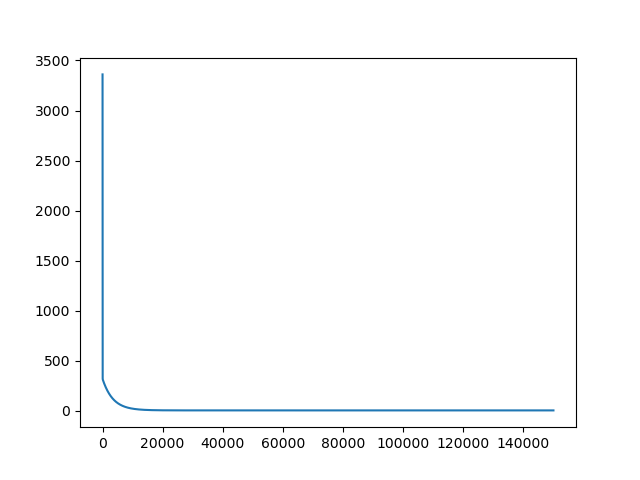

In [17]:
figg, axn = plt.subplots()

axn.plot(range(iters), _)


In [18]:
w_range = np.arange(-2, 4, 0.1)  # try from -1 to 2
b_range = np.arange(-20, 40, 1)

# Create a meshgrid
W, B = np.meshgrid(w_range, b_range)

# Initialize Z with the same shape
Z = np.zeros_like(W)

# Calculate cost for each (w, b) pair
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        Z[i, j] = cost_func(x_train, y_train, np.array([W[i, j]]), B[i, j])
        

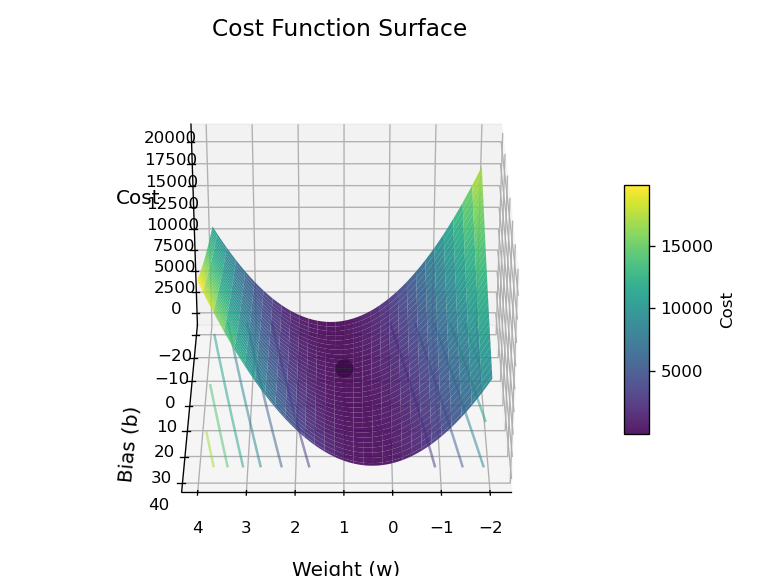

In [19]:
# 5. Create figure with high resolution
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection='3d')

# 6. Plot surface with smooth shading
surf = ax.plot_surface(W, B, Z, cmap='viridis', edgecolor='none', alpha=0.9)

ax.scatter(w, b, cost_func(x_train, y_train ,w, b), color='g', s=100, alpha=1)

# 7. Add contour lines for clarity
ax.contour(W, B, Z, zdir='z', offset=np.min(Z), cmap='viridis', alpha=0.5)

# 8. Labels and title
ax.set_xlabel('Weight (w)', labelpad=10, fontsize=12)
ax.set_ylabel('Bias (b)', labelpad=10, fontsize=12)
ax.set_zlabel('Cost', labelpad=10, fontsize=12)
ax.set_title('Cost Function Surface', fontsize=14, pad=15)

# 9. Color bar
fig.colorbar(surf, shrink=0.5, aspect=10, label='Cost')

# 10. Angle for better 3D viewing
ax.view_init(elev=30, azim=90 )

plt.tight_layout()
plt.show()

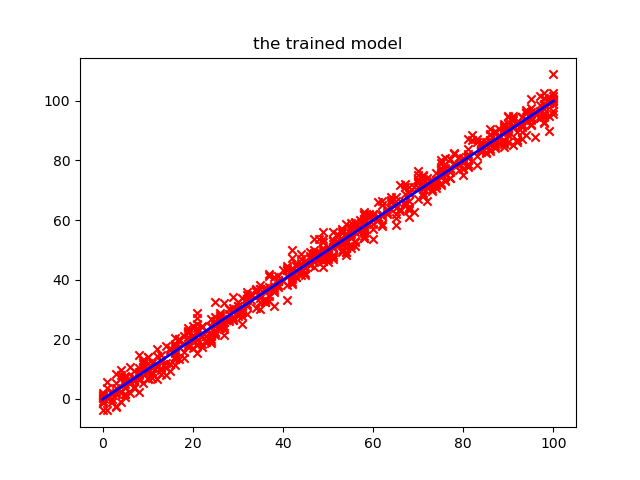

In [20]:
fig, ax = plt.subplots()
ax.set_title("the trained model")
ax.scatter(x_train, y_train, marker='x', color="r")
ax.plot(range(101), np.array(range(101)) * w + b , lw=2, color='b')

In [21]:
pre = 55
print(f"please predict {pre}.")
print(f"of course your prediction is {w * pre + b} ")

please predict 55.
of course your prediction is [54.92883554] 


# the test data

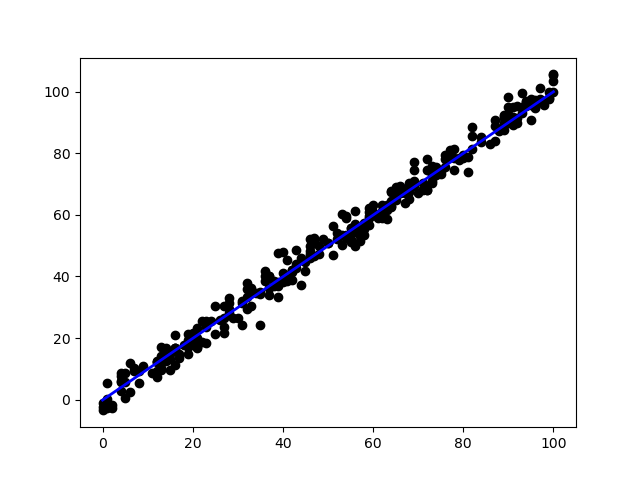

In [22]:
fig, n = plt.subplots()
n.scatter(x_test, y_test, c='black', marker='o')
x_line = np.linspace(x_test.min(), x_test.max(), 100)  # 100 smooth points
y_line = w * x_line + b
n.plot(x_line, y_line, lw=2, color='b')

plt.show()



In [1]:

cost_func(x_test, y_test, w, b)

NameError: name 'cost_func' is not defined